# MNIST 손글씨 - CNN v2
- 2 x Conv2D layers
- 1 MaxPooing2D layer
- 1 FCN layer
- 1 Output layer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 전처리

In [2]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [3]:
# X_train, X_test 정규화(0 ~ 1), 이미지 차원 변경: 2차원 --> 3차원
X_train = X_train.reshape(-1, 28, 28, 1) / 255.
X_test = X_test.reshape(-1, 28, 28, 1) / 255.
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [4]:
# One hot encoding
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

- 모델 정의/설정/학습/평가

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
model = Sequential([
    Conv2D(32, kernel_size=(3,3), input_shape=(28,28,1), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 512)               4719104   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                        

In [7]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

In [8]:
model_path = 'best-mnist-cnn-v2.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

In [9]:
hist = model.fit(
    X_train, Y_train, validation_split=0.2, epochs=100, batch_size=200,
    callbacks=[mc, es]
)

Epoch 1/100
240/240 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9439
Epoch 1: val_loss improved from inf to 0.06043, saving model to best-mnist-cnn-v2.h5
240/240 [==============================] - 14s 15ms/step - loss: 0.1827 - accuracy: 0.9439 - val_loss: 0.0604 - val_accuracy: 0.9818
Epoch 2/100
240/240 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9865
Epoch 2: val_loss improved from 0.06043 to 0.05683, saving model to best-mnist-cnn-v2.h5
240/240 [==============================] - 3s 14ms/step - loss: 0.0439 - accuracy: 0.9865 - val_loss: 0.0568 - val_accuracy: 0.9839
Epoch 3/100
237/240 [============================>.] - ETA: 0s - loss: 0.0262 - accuracy: 0.9916
Epoch 3: val_loss improved from 0.05683 to 0.03805, saving model to best-mnist-cnn-v2.h5
240/240 [==============================] - 3s 14ms/step - loss: 0.0262 - accuracy: 0.9915 - val_loss: 0.0381 - val_accuracy: 0.9890
Epoch 4/100
240/240 [============================

In [10]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0365 - accuracy: 0.9880


[0.03652782738208771, 0.9879999756813049]

- 학습과정 시각화

In [11]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

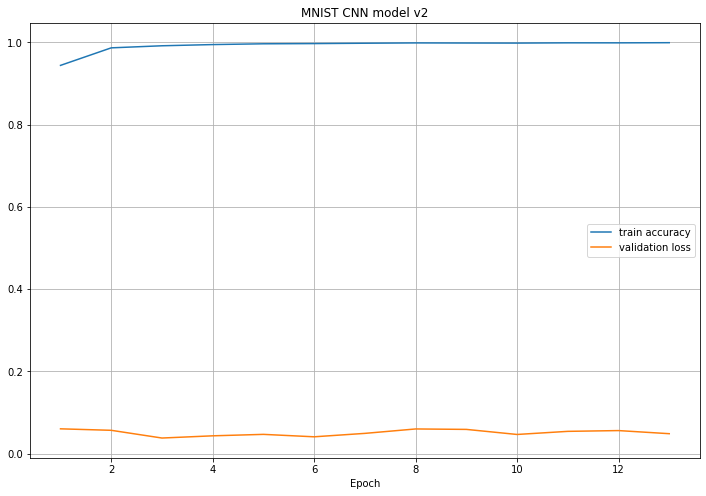

In [13]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend(), plt.grid()
plt.xlabel('Epoch')
plt.title('MNIST CNN model v2')
plt.show()